In [1]:
from math import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF

import xml.etree.ElementTree as ET

import random

import imutils

import sys

import time

from pfld_compressed import PFLDInference
import torch.optim.lr_scheduler as lr_scheduler



In [11]:
from rich import inspect

In [2]:
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [3]:
# if not os.path.exists('data/ibug_300W_large_face_landmark_dataset'):
#     !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
#     !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
#     !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

In [4]:
# type(points[0])


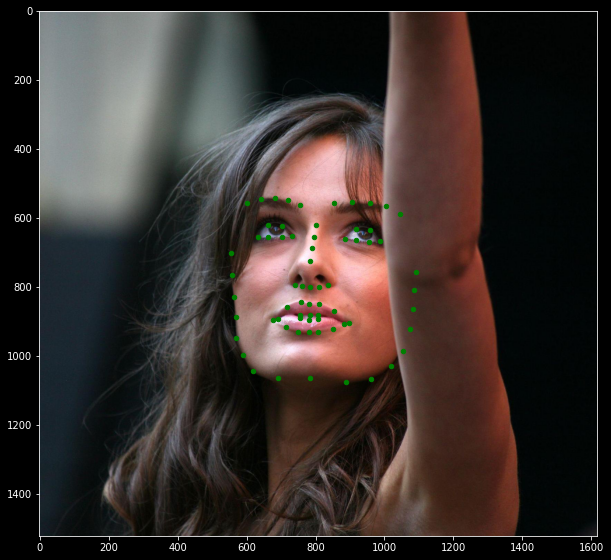

In [5]:
file = open('data/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('data/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 20, c = 'g')
plt.show()

In [6]:
class Transforms():
    def __init__(self, augment):
        self.augment = augment
    
    def rotate(self, image, landmarks, angle):
        # print("rotate")
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        # print("resize")
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        # print("color jitter")
        # color_jitter = transforms.ColorJitter(brightness=0.3, 
        #                                       contrast=0.3,
        #                                       saturation=0.3, 
        #                                       hue=0.1)
        color_jitter = transforms.ColorJitter(brightness=0.1, 
                                              contrast=0.1,
                                              saturation=0.1, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        # image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.resize(image, landmarks, (112, 112))
        if self.augment:
            image, landmarks = self.color_jitter(image, landmarks)
            image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, lbl_path, transform=None):

        tree = ET.parse(lbl_path)
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'data/ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        # image = cv2.imread(self.image_filenames[index], 0) # read img with gray scale
        image = cv2.imread(self.image_filenames[index]) 
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

train_dataset = FaceLandmarksDataset('data/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml',Transforms(True))
valid_dataset = FaceLandmarksDataset('data/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml',Transforms(False))

In [19]:
# img = cv2.imread('data/ibug_300W_large_face_landmark_dataset/helen/trainset/232194_1.jpg',0)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

tree = ET.parse('data/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
print(tree.__dict__)
root = tree.getroot()
print(list(root))

filename = root[2][0].attrib['file']
print(filename)
for i,j in enumerate(filename[0]):
    print(i,j)

{'_root': <Element 'dataset' at 0x7f54cd6609f8>}
[<Element 'name' at 0x7f54cd660b88>, <Element 'comment' at 0x7f54cd660b38>, <Element 'images' at 0x7f54cd660bd8>]
lfpw/trainset/image_0457.png
0 l


In [17]:
root[2][0]

<Element 'image' at 0x7f54e4930d18>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


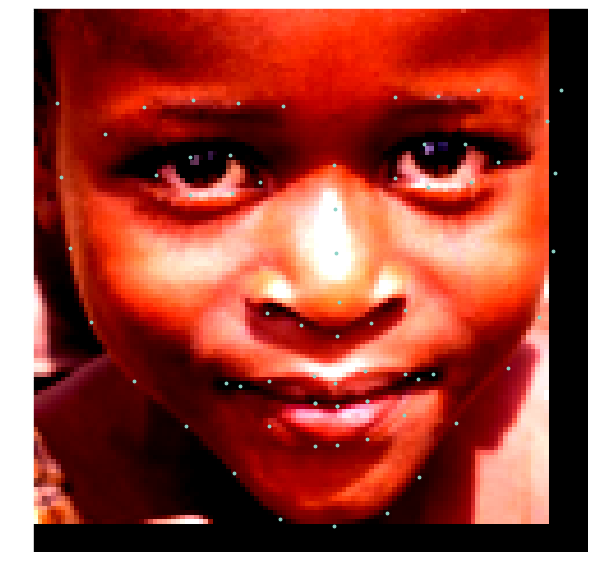

In [68]:
image, landmarks = valid_dataset[3]
# # landmarks = (landmarks + 0.5) * 224
landmarks = (landmarks + 0.5) * 112
plt.figure(figsize=(10, 10))
# # plt.imshow(image.numpy().squeeze(), cmap='gray');
# plt.imshow(image.numpy().squeeze());
plt.imshow(cv2.cvtColor(np.transpose(image.numpy()+0.5,(1,2,0)), cv2.COLOR_BGR2RGB))
plt.scatter(landmarks[:,0], landmarks[:,1], s=8)

In [69]:
# # split the dataset into validation and test sets
# len_valid_set = int(0.1*len(dataset))
# len_train_set = len(dataset) - len_valid_set

# print("The length of Train set is {}".format(len_train_set))
# print("The length of Valid set is {}".format(len_valid_set))
print("The length of Train set is {}".format(len(train_dataset)))
print("The length of Valid set is {}".format(len(valid_dataset)))

# train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=8)

The length of Train set is 6666
The length of Valid set is 1008


In [70]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([128, 3, 112, 112])
torch.Size([128, 68, 2])


In [71]:
# class Network(nn.Module):
#     def __init__(self,num_classes=136):
#         super().__init__()
#         self.model_name='resnet18'
#         self.model=models.resnet18()
#         self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
#     def forward(self, x):
#         x=self.model(x)
#         return x

In [72]:
# model = PFLDInference().cuda()

In [74]:
torch.autograd.set_detect_anomaly(True) # autograd on
# network = Network()
network = PFLDInference()
network.load_state_dict(torch.load('./data/face_landmarks.pth')) 
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[70,80,90], gamma=0.1, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

loss_min = np.inf
# num_epochs = 10
num_epochs = 100

start_time = time.time()
#TODO: add tqdm  print(f'eopch : {epoch+1}/{num_epochs}, iter : {i+1}/{num_iters}, loss : {loss.item():.2f}')    (set_postfix)
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    # for images, landmarks in train_loader:

    # for step in range(1,len(train_loader)+1):
        # images, landmarks = next(iter(train_loader)) 
    for step, (images, landmarks) in enumerate(train_loader, start=1):
 
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step # average loss isn't useful
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        # for step in range(1,len(valid_loader)+1):
        #     images, landmarks = next(iter(valid_loader))
        for step, (images, landmarks) in enumerate(valid_loader, start=1):
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    # scheduler.step()
    scheduler.step(loss_train)
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    # print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('Epoch: {}  Train Loss: {:.2e}  Valid Loss: {:.2e}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), './data/face_landmarks.pth') 
        # print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print("\nMinimum Validation Loss of {:.2e} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 32/32  Loss: 0.0007 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0005  Valid Loss: 0.0007
--------------------------------------------------

Minimum Validation Loss of 0.0007 at epoch 1/100
Model Saved

Valid Steps: 32/32  Loss: 0.0007 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0004  Valid Loss: 0.0007
--------------------------------------------------
Valid Steps: 32/32  Loss: 0.0007 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0005  Valid Loss: 0.0007
--------------------------------------------------

Minimum Validation Loss of 0.0007 at epoch 3/100
Model Saved

Valid Steps: 32/32  Loss: 0.0007 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0004  Valid Loss: 0.0007
--------------------------------------------------
Valid Steps: 32/32  Loss: 0.0007 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0004  Valid Loss: 0.0007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

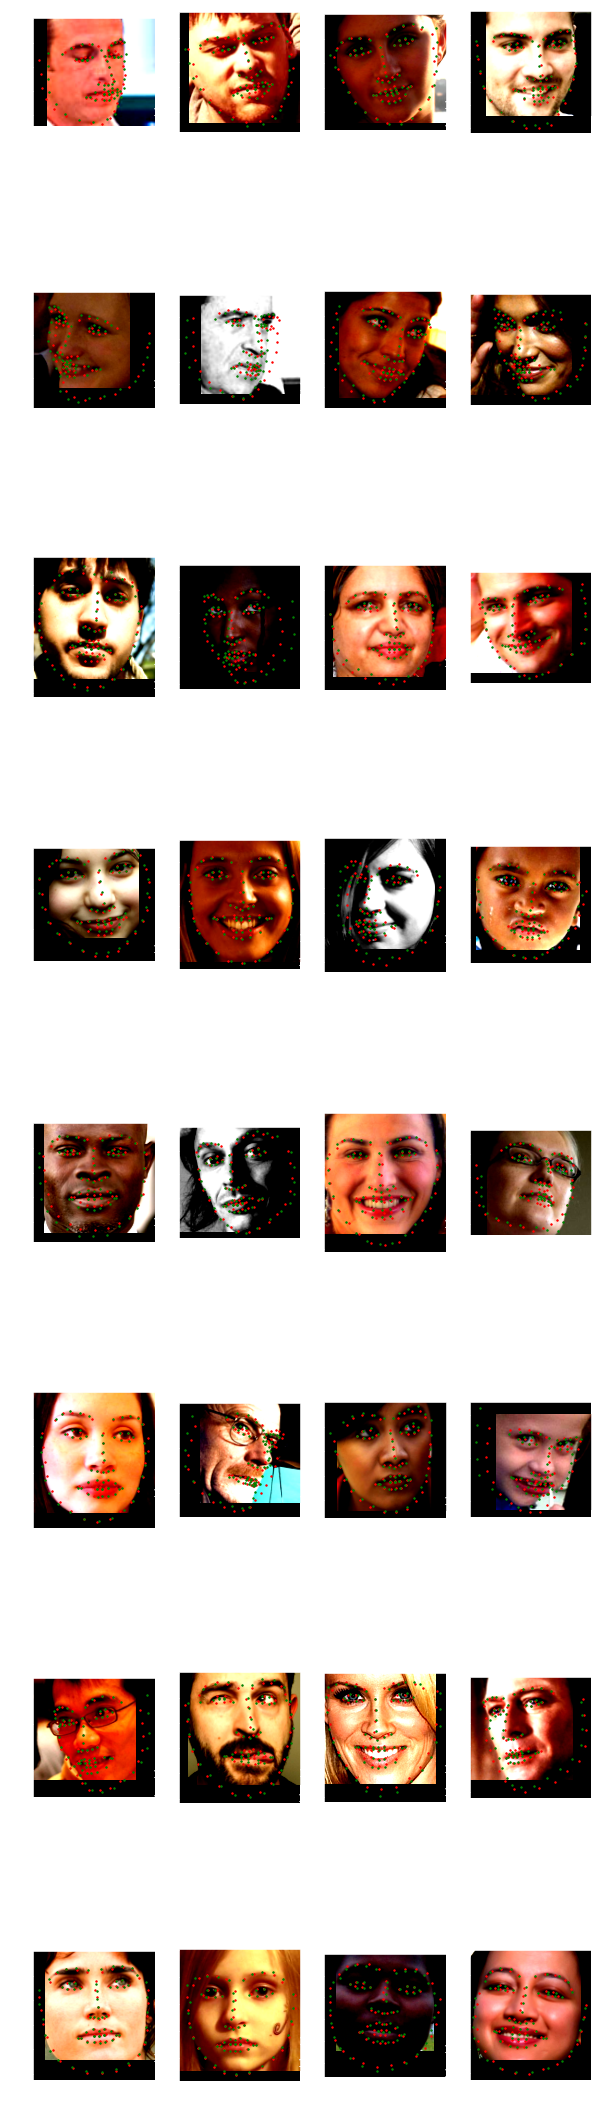

In [75]:
start_time = time.time()

with torch.no_grad():

    # best_network = Network()
    best_network = PFLDInference()
    best_network.cuda()
    best_network.load_state_dict(torch.load('./data/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    # landmarks = (landmarks + 0.5) * 224
    landmarks = (landmarks + 0.5) * 112

    # predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = (best_network(images).cpu() + 0.5) * 112
    predictions = predictions.view(-1,68,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(32):
        # plt.subplot(32,1,img_num+1)
        plt.subplot(8,4,img_num+1)
        # plt.imshow(cv2.cvtColor(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.cvtColor(images[img_num].cpu().numpy().transpose(1,2,0)+0.5, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 2)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 2)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 